## scikit-learn digits dataset example

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from keras_ex.GaussianKernel import GaussianKernel, GaussianKernel2, GaussianKernel3

# or copy and paste the definition of `GaussianKernel` here.

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

In [4]:
digits = load_digits()
X, y = digits.data, digits.target

In [5]:
X = X.reshape((X.shape[0], -1))

In [6]:
X_sc = X / 16.0
X_sc.shape

(1797, 64)

In [7]:
X_sc_train, X_sc_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.4, random_state=0)
print(X_sc_train.shape)
print(X_sc_test.shape)
print(y_train.shape)
print(y_test.shape)

(1078, 64)
(719, 64)
(1078,)
(719,)


In [8]:
y_cat = to_categorical(y)
y_cat.shape

(1797, 10)

In [9]:
y_cat_train = to_categorical(y_train)
y_cat_train.shape

(1078, 10)

In [10]:
y_cat_test = to_categorical(y_test)
y_cat_test.shape

(719, 10)

In [11]:
def get_lm(smpl, y, num_lm0=20, random_state=0):
    cls = sorted(np.unique(y))
    np.random.seed(random_state)
    num_feature = np.prod(smpl.shape[1:])
    shape = np.hstack([num_lm0, smpl.shape[1:]])
    num_lm = num_lm0 * len(cls)
    init_list = []
    for ii in cls:
        init_wgt0 = smpl[y==ii]
        init_wgt0 = init_wgt0[np.random.choice(range(init_wgt0.shape[0]), size=num_lm0, replace=False)] + \
                    np.random.normal(scale=0.002, size=num_lm0*num_feature).reshape(shape)
        init_list.append(init_wgt0)
    init_wgt = np.vstack(init_list)
    init_wgt = init_wgt[np.random.permutation(range(init_wgt.shape[0]))]
    return init_wgt

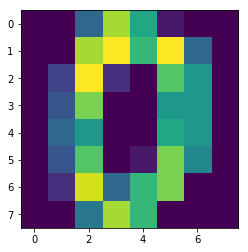

In [12]:
plt.imshow(X[0].reshape((8,8)))

### create model

In [13]:
'''
chose landmarks on input data
pick 20 data each digit
'''
num_lm0 = 20
num_lm = num_lm0 * 10

init_wgt = get_lm(X_sc_train, y_train, num_lm0=num_lm0)
init_wgt.shape

(200, 64)

In [14]:
'''
chose landmarks randomly for gk2
'''
#num_lm2 = 200
num_lm2 = 10
init_lm2 = np.random.random_sample((num_lm2, num_lm))
print(init_lm2.shape)
init_lm2

(10, 200)


array([[ 0.72150955,  0.73561866,  0.82786211, ...,  0.41821092,
         0.89579757,  0.91663392],
       [ 0.53282433,  0.95938975,  0.4606461 , ...,  0.34725582,
         0.52960293,  0.74073731],
       [ 0.19641256,  0.93073513,  0.27859638, ...,  0.40815083,
         0.74430385,  0.842343  ],
       ..., 
       [ 0.03160016,  0.13718324,  0.13656883, ...,  0.02309561,
         0.84539496,  0.80830776],
       [ 0.99771232,  0.54711599,  0.12419023, ...,  0.12487177,
         0.31043308,  0.99672953],
       [ 0.1143734 ,  0.87510768,  0.00171543, ...,  0.69388459,
         0.66499431,  0.46904023]])

In [15]:
np.random.seed(0)

def make_modelz(wgt_embed=None):
    '''==============================
    inputs
    =============================='''
    inp_cls = Input(shape=(10,), name='input_cls')
    inp_img = Input(shape=(64,), name='input_img')
    inp_200 = Input(shape=(num_lm,), name='input_200')
    
    '''==============================
    layers
    =============================='''
    if wgt_embed is None:
        layer_dense_embed = Dense(64, use_bias=False, name='embed')
    else:
        layer_dense_embed = Dense(64, use_bias=False, name='embed', weights=[wgt_embed])
    layer_dense_ae = Dense(64, name='dense_ae')
    
    '''Gaussian Kernel 1'''
    weights1 = [init_wgt, np.log(np.array([1./(2.*64*0.1)]))]
    layer_gk1 = GaussianKernel3(num_lm, 64, name='gkernel1', weights=weights1)
    
    '''Gaussian Kernel 2'''
    weights2 = [init_lm2, np.log(np.array([1./(2.*num_lm*0.1)]))]
    layer_gk2 = GaussianKernel3(10, num_lm, weights=weights2, name='gkernel2')
    
    '''==============================
    models
    =============================='''
    oup_gk1 = layer_gk1(inp_img)
    model_gk1 = Model(inp_img, oup_gk1, name='model_gk1')
    
    oup_gk2 = layer_gk2(inp_200)
    model_classify = Model(inp_200, oup_gk2, name='model_classify')
    
    model_embed = Model(inp_cls, layer_dense_embed(inp_cls), name='model_embed')
    
    # ae
    oup_ae = layer_dense_ae(inp_200)
    model_ae = Model(inp_200, oup_ae, name='model_ae')
    
    # img > img
    oup_img_img = model_ae(oup_gk1)
    oup_img_img = Activation('sigmoid', name='output_img')(oup_img_img)
    model_img_img = Model(inp_img, oup_img_img, name='model_img_img')
    
    # img > cls
    oup_img_cls = model_classify(oup_gk1)
    model_img_cls = Model(inp_img, oup_img_cls, name='model_img_cls')
    
    # cls > img
    model_cls_img = Model(inp_cls, model_img_img(model_embed(inp_cls)), name='model_cls_img')
    
    # cls > cls
    model_cls_cls = Model(inp_cls, model_img_cls(model_embed(inp_cls)), name='model_cls_cls')
    
    '''==============================
    cost functions
    =============================='''
    def cost_cls(y_true, y_pred):
        return losses.categorical_crossentropy(y_true, y_pred)
    def cost_ae(y_true, y_pred):
        return losses.mse(y_true, y_pred)
    def cost_zero(y_true, y_pred):
        return losses.mse(0, y_pred)
    
    '''=== img -> imgA ==='''
    pass_img_imgA = model_img_img(inp_img)
    pass_img_imgA = Activation('linear', name='pass_img_imgA')(pass_img_imgA)
    
    '''=== cls -> img ==='''
    pass_cls_img = model_cls_img(inp_cls)
    pass_cls_img = Activation('linear', name='pass_cls_img')(pass_cls_img)
    
    '''=== cls -> img -> cls ==='''
    pass_cls_img_cls = model_img_cls(pass_cls_img)
    model_cls_img_cls = Model(inp_cls, pass_cls_img_cls, name='model_cls_img_cls')
    pass_cls_img_cls = Activation('softmax', name='pass_cls_img_cls')(pass_cls_img_cls)
    
    pass_fit_imgA = Lambda(lambda x: x[0] - x[1], name='pass_fit_imgA')([
        pass_img_imgA,
        pass_cls_img
    ])
    
    model = Model([inp_img, inp_cls],
                  [pass_cls_img, pass_fit_imgA])
    model.compile(loss={
                     'pass_cls_img': cost_ae,
                     'pass_fit_imgA': cost_zero,
                  },
                  loss_weights={
                     'pass_cls_img': 1.0,
                     'pass_fit_imgA': 1.0,
                  },
                  metrics=['accuracy'],
                  optimizer='adam')
    
    return {
        'model': model,
        'model_embed': model_embed,
        'model_ae': model_ae,
        'model_gk1': model_gk1,
        'model_classify': model_classify,
        
        'model_img_img': model_img_img,
        'model_img_cls': model_img_cls,
        'model_cls_img': model_cls_img,
        'model_cls_cls': model_cls_cls,
        
        'model_cls_img_cls': model_cls_img_cls,
    }

models = make_modelz()
model = models['model']
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_cls (InputLayer)           (None, 10)            0                                            
____________________________________________________________________________________________________
input_img (InputLayer)           (None, 64)            0                                            
____________________________________________________________________________________________________
model_cls_img (Model)            (None, 64)            26305       input_cls[0][0]                  
____________________________________________________________________________________________________
model_img_img (Model)            (None, 64)            25665       input_img[0][0]                  
___________________________________________________________________________________________

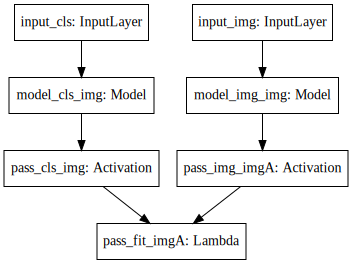

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### train

In [ ]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

In [ ]:
model.fit({'input_img': X_sc_train, 'input_cls': y_cat_train},
          {
              'pass_cls_img': X_sc_train,
              'pass_fit_imgA': X_sc_train,
          },
          validation_data=(
              {'input_img': X_sc_test, 'input_cls': y_cat_test},
              {
                  'pass_cls_img': X_sc_test,
                  'pass_fit_imgA': X_sc_test,
              }
          ),
          verbose=0,
          batch_size=32,
          epochs=150)

### img > associated img

In [ ]:
pred_img = models['model_img_img'].predict({'input_img': X_sc, 'input_cls': y_cat}, batch_size=32, verbose=1)
print(pred_img.shape)

In [ ]:
nrows=2
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for jj in range(ncols):
    iplt = subs[0, jj]
    img_array = X_sc[jj].reshape((8,8))
    iplt.imshow(img_array)
    iplt = subs[1, jj]
    img_array = pred_img[jj].reshape((8,8))
    iplt.imshow(img_array)

In [ ]:
nrows=2
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for jj in range(ncols):
    iplt = subs[0, jj]
    img_array = X_sc[jj+20].reshape((8,8))
    iplt.imshow(img_array)
    iplt = subs[1, jj]
    img_array = pred_img[jj].reshape((8,8))
    iplt.imshow(img_array)

In [ ]:
idx = 0
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(pred_img[idx].reshape((8,8)))

### abstract images of digits

In [ ]:
pred_img = models['model_cls_img'].predict({'input_img': X_sc, 'input_cls': y_cat}, batch_size=32, verbose=1)
print(pred_img.shape)

In [ ]:
nrows=1
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3))

for jj in range(ncols):
    iplt = subs[jj]
    img_array = pred_img[jj].reshape((8,8))
    iplt.imshow(img_array)

### plot weights of embed layer

In [ ]:
wgt_dense = models['model_embed'].get_layer('embed').get_weights()[0]
#wgt_dense = 1 / (1 + np.exp(-wgt_dense))
print(wgt_dense.shape)

nrows=1
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[jj]
        img_array = wgt_dense[jj].reshape((8,8))
        iplt.imshow(img_array)

In [ ]:
pred_img = models['model_img_img'].predict({'input_img': wgt_dense}, batch_size=32, verbose=1)
print(pred_img.shape)

nrows=1
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[jj]
        img_array = pred_img[jj].reshape((8,8))
        iplt.imshow(img_array)

### plot output of model_embed

In [ ]:
pred_ae_embed = models['model_embed'].predict(y_cat)
pred_ae_embed.shape

In [ ]:
nrows=1
ncols=10
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[jj]
        img_array = pred_ae_embed[jj].reshape((8,8))
        iplt.imshow(img_array)

### plot output of GaussianKernel layer #1

In [ ]:
pred_imgA_train = models['model_img_img'].predict({'input_img': X_sc_train}, batch_size=32, verbose=1)
print(pred_imgA_train.shape)

In [ ]:
gk1_pred = models['model_gk1'].predict({'input_img': pred_imgA_train}, batch_size=32, verbose=1)
df = pd.DataFrame(gk1_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y_train]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

In [ ]:
df = pd.DataFrame(gk1_pred[:,50:55])
df['cls'] = ['c'+str(ee) for ee in y_train]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### show landmarks

In [ ]:
wgt = models['model_img_img'].get_layer('gkernel1').get_weights()[0]
wgt.shape

In [ ]:
df = pd.DataFrame(wgt[:,:5])
sns.pairplot(df, markers='.', size=2.2)

In [ ]:
df = pd.DataFrame(wgt[:,50:55])
sns.pairplot(df, markers='.', size=2.2)

In [ ]:
plt.imshow(wgt[0].reshape((8,8)))

In [ ]:
nrows = 10
ncols = num_lm0
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[ii,jj]
        img_array = wgt[ii*ncols+jj].reshape((8, 8))
        iplt.imshow(img_array)